
# Klasifikasi Penyakit Daun Tebu Menggunakan VGG-19

Notebook ini menggunakan transfer learning dengan model VGG-19 untuk mengklasifikasikan penyakit pada daun tebu.


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



## Persiapan Dataset

Dataset harus memiliki struktur berikut:

```
dataset/
|-- train/
|   |-- class_1/
|   |-- class_2/
|   |-- ...
|-- validation/
|   |-- class_1/
|   |-- class_2/
|   |-- ...
```

Letakkan dataset Anda di folder `dataset/`.


In [2]:
# Path ke folder dataset
train_dir = 'archive/train'
val_dir = 'archive/validation'

# Data Augmentation dan Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Ukuran gambar
img_size = (224, 224)

# Load train dan validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Penting untuk evaluasi
)



Found 1758 images belonging to 3 classes.
Found 502 images belonging to 3 classes.


## Membangun Model dengan VGG-19

In [ ]:
# Load model pre-trained VGG-19 tanpa fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua lapisan awal VGG19
base_model.trainable = False

model = Sequential()

# Menambahkan semua lapisan dari base_model
for layer in base_model.layers:
    model.add(layer)

# Menambahkan lapisan tambahan
model.add(Flatten()) 
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Fungsi aktivasi softmax

model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',     
    metrics=['accuracy']                 
)

# Tampilkan ringkasan model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

: 

## Melatih Model

In [ ]:
# Callback Early Stopping
print("Starting training...")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=17,
    callbacks=[early_stopping]
)
print("Training finished.")

Starting training...
Epoch 1/17


## Visualisasi Hasil Pelatihan

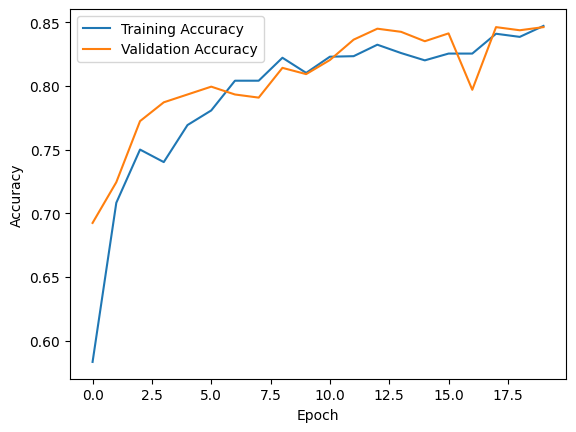

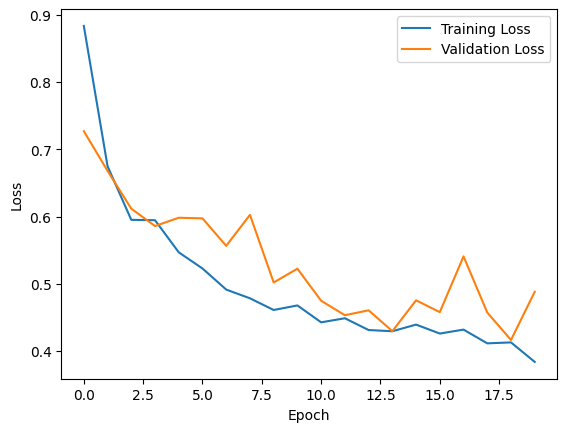

In [ ]:
# Plot akurasi training dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

26/26 [==============================] - 174s 7s/step


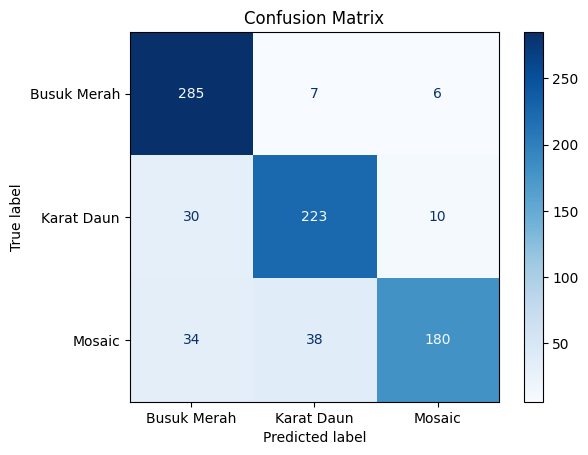


Classification Report:
              precision    recall  f1-score   support

 Busuk Merah       0.82      0.96      0.88       298
  Karat Daun       0.83      0.85      0.84       263
      Mosaic       0.92      0.71      0.80       252

    accuracy                           0.85       813
   macro avg       0.86      0.84      0.84       813
weighted avg       0.85      0.85      0.84       813



In [ ]:
# Evaluasi Model dengan Confusion Matrix
def plot_confusion_matrix(model, val_generator):
    y_true = val_generator.classes
    y_pred = model.predict(val_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Tambahkan laporan klasifikasi
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

plot_confusion_matrix(model, val_generator)


## Menyimpan Model

In [ ]:
# Simpan model yang sudah dilatih
model.save('CNN.h5')
print("Model saved as 'adagrad.h5'")


d:\Latihan Web\Tebu\Model Tebu\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'vgg19_sugarcane_leaf_disease_kopi.h5'


# mencoba 

1/1 [==============================] - 1s 567ms/step
Predicted class: Mosaic with probability 0.6743


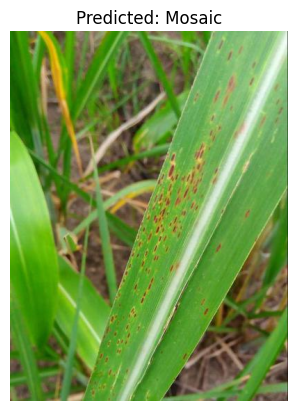

In [ ]:
# Fungsi prediksi
# Fungsi prediksi
def predict_image(image_path, model, class_labels, threshold=0.5):
    """
    Fungsi untuk memprediksi kelas gambar dan menghindari prediksi yang tidak relevan.
    
    Args:
        image_path (str): Path ke gambar.
        model (keras.Model): Model yang sudah dilatih.
        class_labels (list): Daftar label kelas.
        threshold (float): Ambang batas probabilitas prediksi untuk menentukan apakah gambar relevan.

    Returns:
        str: Label kelas yang diprediksi atau "Unknown" jika probabilitas prediksi rendah.
    """
    # Load dan preprocess gambar
    img = load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran input model
    img_array = img_to_array(img) / 255.0  # Normalisasi [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Prediksi kelas
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    predicted_prob = np.max(predictions)  # Ambil probabilitas tertinggi dari kelas yang diprediksi
    
    if predicted_prob < threshold:
        predicted_label = "Unknown"  # Jika probabilitas terlalu rendah, beri label "Unknown"
    else:
        predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label} with probability {predicted_prob:.4f}")
    return predicted_label


# Contoh penggunaan
# Ganti 'image_path' dengan path gambar Anda
image_path = '2.jpg'  # Pastikan path gambar benar
class_labels = list(train_generator.class_indices.keys())  # Ambil label kelas
predicted_label = predict_image(image_path, model, class_labels)

# Tampilkan gambar dan hasil prediksi
img = load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
